**Diabetic Retinopathy** <br>
Diabetic retinopathy (DR) is a medical condition in which damage occurs to the retina due to diabetes mellitus. It is a leading cause of blindness. Diabetic retinopathy affects up to 80 percent of those who have had diabetes for 20 years or more.<br>
Diabetic retinopathy often has no early warning signs. Retinal (fundus) photography with manual interpretation is a widely accepted screening tool for diabetic retinopathy, with performance that can exceed that of in-person dilated eye examinations.<br><br>
**problem statement:**<br> To build a machine learning model to speed up disease detection and to help identify diabetic retinopathy automatically.<br><br>**Dataset**<br> kaggle:-https://www.kaggle.com/c/aptos2019-blindness-detection  



In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [0]:
# dependencies
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
# Path specifications
KAGGLE_DIR = '../input/aptos2019-blindness-detection/'
TRAIN_DF_PATH = KAGGLE_DIR + "train.csv"
TEST_DF_PATH = KAGGLE_DIR + 'test.csv'
TRAIN_IMG_PATH = KAGGLE_DIR + "train_images/"
TEST_IMG_PATH = KAGGLE_DIR + 'test_images/'

In [0]:
# Specify image size
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3

In [0]:
# preparation
# loading data
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print (train_df.shape)
print (test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [0]:
# Specify image size
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3

In [0]:
# creating dataframes train and test
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DF_PATH)
# Add extension to id_code
train_df['id_code'] = train_df['id_code'] + ".png"
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DF_PATH)
# Add extension to id_code
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


In [0]:
# number of images in each class
train_df.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [0]:
# Labels for training data
y_labels = train_df['diagnosis'].values
y_labels[:5]

array([2, 4, 1, 0, 0])

0    1805
1     370
2     999
3     193
4     295
Name: diagnosis, dtype: int64

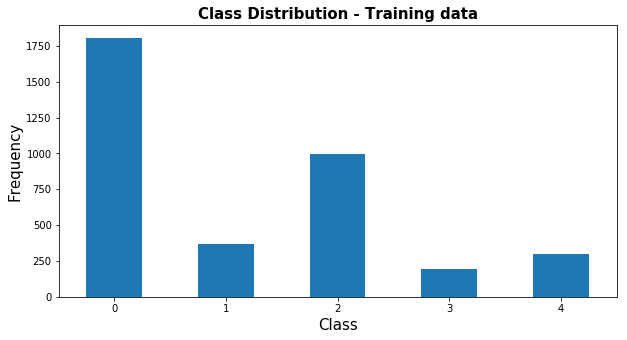

In [0]:
# EDA- distribution of classes in training dataset
import matplotlib.pyplot as plt
train_df.diagnosis.value_counts().sort_index().plot(kind = 'bar', figsize = (10,5), rot = 0)
plt.title('Class Distribution - Training data', weight = 'bold', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Class', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

train_df.diagnosis.value_counts().sort_index()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `item` has been deprecated and will be removed in a future version
  


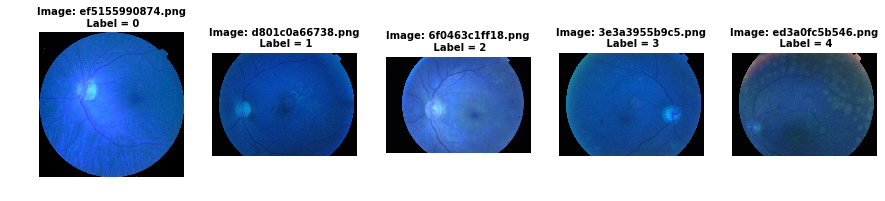

In [0]:
# taking a look at image from each class
import cv2
SEED = 42
fig, ax = plt.subplots(1,5,figsize = (15,5))
for i in range(5):
    sample = train_df[train_df.diagnosis == i].sample(1,random_state=SEED)
    image_name = sample['id_code'].item()
    X = cv2.imread(f'{TRAIN_IMG_PATH}{image_name}')
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X)
    
    

**Ben Graham's preprocessing method**<br>
Ben Graham ([previous competition's winner](https://github.com/btgraham/SparseConvNet/tree/kaggle_Diabetic_Retinopathy_competition)) share insightful way to improve lighting condition. Here, we apply his idea, and can see many important details in the eyes much better.


In [0]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


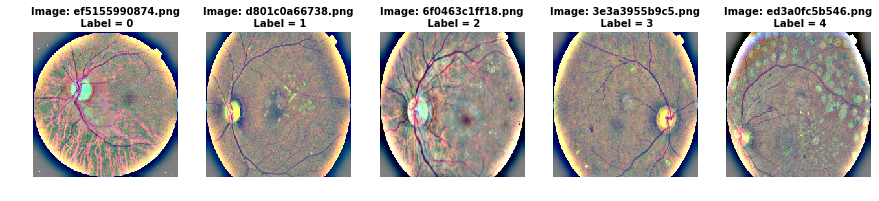

In [0]:
fig, ax = plt.subplots(1,5,figsize = (15,5))
for i in range(5):
    sample = train_df[train_df.diagnosis == i].sample(1,random_state=SEED)
    image_name = sample['id_code'].item()
    X = preprocess_image(cv2.imread(f'{TRAIN_IMG_PATH}{image_name}'))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X)

In [0]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')
        return

In [0]:
# replace number to names
replace_map = {'diagnosis':{0:'No_DR',1:'Mild',2:'Moderate',3:'Severe',4:'Proliferate_DR'}}

In [0]:
train_df.replace(replace_map, inplace = True)
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,Moderate
1,001639a390f0.png,Proliferate_DR
2,0024cdab0c1e.png,Mild
3,002c21358ce6.png,No_DR
4,005b95c28852.png,No_DR


In [0]:
# we are going to apply tranfer learning using densenet-121
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [0]:
# building model using Densenet-121
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [0]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [0]:
# add image agumentation to our generator
BATCH_SIZE = 32
datagen = ImageDataGenerator(rotation_range = 360,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  validation_split = 0.15,
                                  preprocessing_function = preprocess_image,
                                  rescale = 1/128
                                  )

train_generator = datagen.flow_from_dataframe(train_df, 
                                              x_col = 'id_code',
                                              y_col = 'diagnosis',
                                              directory = TRAIN_IMG_PATH,
                                              target_size = (IMG_WIDTH, IMG_HEIGHT),
                                              batch_size = BATCH_SIZE,
                                              class_mode="categorical",
                                              subset = 'training')


val_generator = datagen.flow_from_dataframe(train_df, 
                                            x_col = 'id_code',
                                            y_col = 'diagnosis',
                                            directory = TRAIN_IMG_PATH,
                                            target_size = (IMG_WIDTH, IMG_HEIGHT),
                                            batch_size = BATCH_SIZE,
                                            class_mode="categorical",
                                            subset = 'validation')

Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


In [0]:
# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()
    
 

# Begin training
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics ])


Epoch 1/20
97/97 [==============================] - 497s 5s/step - loss: 1.1827 - acc: 0.6124 - val_loss: 0.6320 - val_acc: 0.7739
val_kappa: 0.7137
Validation Kappa has improved. Saving model.
Epoch 2/20
97/97 [==============================] - 384s 4s/step - loss: 0.7980 - acc: 0.7205 - val_loss: 0.6053 - val_acc: 0.7621
val_kappa: 0.7174
Validation Kappa has improved. Saving model.
Epoch 3/20
97/97 [==============================] - 373s 4s/step - loss: 0.6861 - acc: 0.7582 - val_loss: 0.5743 - val_acc: 0.7814
val_kappa: 0.7377
Validation Kappa has improved. Saving model.
Epoch 4/20
97/97 [==============================] - 375s 4s/step - loss: 0.6179 - acc: 0.7749 - val_loss: 0.5487 - val_acc: 0.7950
val_kappa: 0.7337
Epoch 5/20
97/97 [==============================] - 377s 4s/step - loss: 0.5923 - acc: 0.7915 - val_loss: 0.5080 - val_acc: 0.8027
val_kappa: 0.7477
Validation Kappa has improved. Saving model.
Epoch 6/20
97/97 [==============================] - 374s 4s/step - loss: 0.

Text(0, 0.5, '% Accuracy')

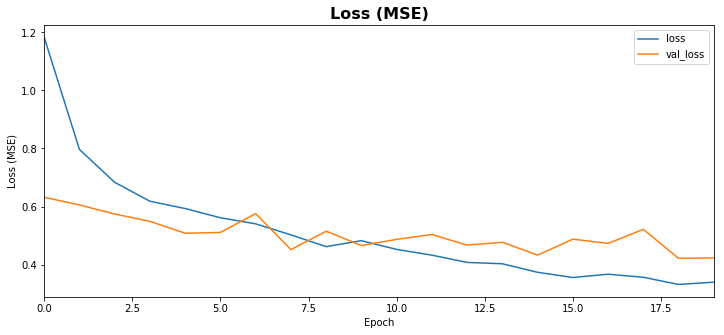

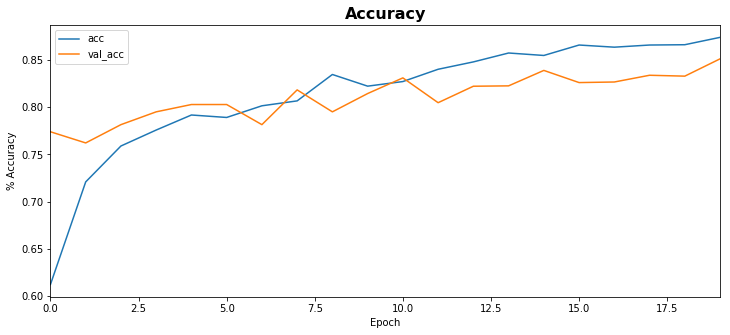

In [0]:
# Visualize mse
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy")

In [0]:
test_datagen=ImageDataGenerator(rescale=1./255,preprocessing_function = preprocess_image)

test_generator = test_datagen.flow_from_dataframe(test_df, 
                                              x_col = 'id_code',
                                              y_col = None,
                                              directory = TEST_IMG_PATH,
                                              target_size = (IMG_WIDTH, IMG_HEIGHT),
                                              batch_size = BATCH_SIZE,
                                              class_mode=None,
                                              subset = 'training')

Found 1928 validated image filenames.


In [0]:
model.evaluate_generator(generator = val_generator, steps =test_generator.samples // BATCH_SIZE )

In [0]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)